# 🧪 Digital Gait Laboratory: Hybrid Architecture

**Course:** Wearable Computing & Gait Analysis (Master's Level)  
**Topic:** Sensor Fusion and Hybrid Deep Learning

## 1. Introduction and Objective

In this laboratory, we implement a **Hybrid Neural Network** for Human Activity Recognition (HAR). Standard Deep Learning (CNNs) is excellent at finding local temporal patterns, but it can sometimes miss global statistical properties of the signal.

To maximize accuracy, we use a two-branch architecture:
1.  **Branch A (CNN):** Inputs the raw time-series signal (Automatic Feature Extraction).
2.  **Branch B (MLP):** Inputs manually calculated statistical features (Domain Knowledge).

We will process the **UCI HAPT** dataset, combining raw sensor data with features like **Jerk**, **Spectral Entropy**, and **Signal Magnitude**.

## 2. Environment Setup

We import the necessary libraries. We will use `scipy` for signal processing (filtering and FFT) and `torch` for building the neural network.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Signal Processing
from scipy.signal import butter, lfilter
from scipy.fft import fft
from scipy.stats import iqr, entropy

# Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Computation Device: {device}")

Computation Device: cuda


## 3. Configuration Parameters

Defining constants at the start ensures reproducibility. 
* **Window Size:** 128 samples (approx 2.56 seconds at 50Hz).
* **Overlap:** 50% overlap ensures we don't miss events occurring at the edge of a window.

In [2]:
FS = 50              # Sampling Frequency (Hz)
WINDOW_SIZE = 128    # Samples per window
OVERLAP = 64         # Samples of overlap
BATCH_SIZE = 32      # Neural Network batch size
EPOCHS = 40          # Training iterations
LEARNING_RATE = 0.0005

## 4. Signal Preprocessing: Gravity Separation

Accelerometers measure **Total Acceleration**, which is the sum of:
1.  **Body Acceleration:** The movement of the user (Dynamic).
2.  **Gravity:** The constant pull of the earth (Static/Low Frequency).

To analyze movement correctly, we must separate these components using a **Low-Pass Filter** (Butterworth).

In [3]:
def separate_gravity(data, fs=50):
    """
    Separates the gravity component from the body acceleration.
    Gravity is low-frequency (slow changing), Body Acc is high-frequency.
    """
    # Calculate the cutoff frequency normalized to Nyquist
    nyquist_freq = 0.5 * fs
    cutoff_freq = 0.3  # 0.3 Hz cutoff
    normalized_cutoff = cutoff_freq / nyquist_freq
    
    # Design the Butterworth filter
    b, a = butter(3, normalized_cutoff, btype='low', analog=False)
    
    # Apply filter
    gravity = lfilter(b, a, data, axis=0)
    body_acc = data - gravity
    
    return body_acc, gravity

## 5. Advanced Feature Extraction

This is the core of the "Hybrid" approach. For every window of data (128 steps), we extract a single vector of statistical summaries.

**Features extracted per axis:**
1.  **Temporal:** Mean, Std Dev, Min, Max, Energy, IQR (Interquartile Range).
2.  **Frequency (FFT):** Dominant Frequency, Spectral Energy, Spectral Entropy.
3.  **Physics:** Jerk (smoothness), Magnitude (intensity), Angle (posture).



In [4]:
def extract_features(window):
    """
    Input: A window of shape (128, 9) containing:
           [BodyAcc (3), Gyro (3), TotalAcc (3)]
    Output: A 1D array of calculated features.
    """
    features = []
    
    # 1. Split the window into specific sensors
    body_acc = window[:, 0:3]  # Columns 0, 1, 2
    gyro = window[:, 3:6]      # Columns 3, 4, 5
    total_acc = window[:, 6:9] # Columns 6, 7, 8
    
    # 2. Derive "Jerk" Signals (Derivative of acceleration/gyro)
    # We use padding so the length remains 128
    acc_jerk = np.diff(body_acc, axis=0, prepend=body_acc[0:1, :])
    gyro_jerk = np.diff(gyro, axis=0, prepend=gyro[0:1, :])
    
    # 3. Derive Magnitudes (Euclidean Norm)
    acc_mag = np.linalg.norm(body_acc, axis=1)
    gyro_mag = np.linalg.norm(gyro, axis=1)
    acc_jerk_mag = np.linalg.norm(acc_jerk, axis=1)
    gyro_jerk_mag = np.linalg.norm(gyro_jerk, axis=1)
    
    # --- SECTION A: TIME DOMAIN STATISTICS ---
    
    # List of all 3-axis signals to process
    multi_axis_signals = [body_acc, gyro, acc_jerk, gyro_jerk]
    
    for signal in multi_axis_signals:
        # signal shape is (128, 3). calculating axis=0 gives 3 values (x,y,z)
        features.extend(np.mean(signal, axis=0))
        features.extend(np.std(signal, axis=0))
        features.extend(np.max(signal, axis=0))
        features.extend(np.min(signal, axis=0))
        features.extend(iqr(signal, axis=0))
        features.extend(np.sum(signal**2, axis=0) / len(window)) # Energy
        
    # List of all magnitude (1-axis) signals
    magnitude_signals = [acc_mag, gyro_mag, acc_jerk_mag, gyro_jerk_mag]
    
    for mag in magnitude_signals:
        features.append(np.mean(mag))
        features.append(np.std(mag))
        features.append(np.max(mag))
        features.append(iqr(mag))

    # --- SECTION B: FREQUENCY DOMAIN (FFT) ---
    
    # We only apply FFT to Body Acc and Gyro
    fft_inputs = [body_acc, gyro]
    
    for signal in fft_inputs:
        for axis in range(3):
            col = signal[:, axis]
            
            # Compute Fast Fourier Transform
            # We take the first half because real-valued FFT is symmetric
            fft_values = np.abs(fft(col))[:len(window)//2]
            
            # Feature 1: Spectral Mean (Average energy in freq domain)
            features.append(np.mean(fft_values))
            
            # Feature 2: Spectral Entropy (Measure of signal complexity)
            # Normalize to treat as a probability distribution
            psd = fft_values / (np.sum(fft_values) + 1e-9)
            features.append(entropy(psd))
            
            # Feature 3: Dominant Frequency (Index of max power)
            features.append(np.argmax(fft_values))

    # --- SECTION C: CORRELATION & ANGLE ---
    
    # Correlation between Body Acc axes (X-Y, X-Z, Y-Z)
    features.append(np.corrcoef(body_acc[:,0], body_acc[:,1])[0,1])
    features.append(np.corrcoef(body_acc[:,0], body_acc[:,2])[0,1])
    features.append(np.corrcoef(body_acc[:,1], body_acc[:,2])[0,1])
    
    # Angle between Body Acc vector and Gravity vector
    mean_total = np.mean(total_acc, axis=0)
    mean_body = np.mean(body_acc, axis=0)
    
    numerator = np.dot(mean_total, mean_body)
    denominator = np.linalg.norm(mean_total) * np.linalg.norm(mean_body) + 1e-9
    angle = np.arccos(np.clip(numerator/denominator, -1.0, 1.0))
    features.append(angle)

    # Convert list to numpy array and handle any NaNs
    return np.nan_to_num(np.array(features))

## 6. Dataset Preparation

Here we download the UCI HAPT dataset and format it. We iterate through the raw text files, segment them into windows, and run the `extract_features` function defined above.

In [5]:
# Download Logic
dataset_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00341/HAPT%20Data%20Set.zip"
zip_path = "HAPT_Data_Set.zip"
extract_folder = "HAPT_Dataset"

if not os.path.exists(extract_folder):
    print("Downloading dataset...")
    !wget -q $dataset_url -O $zip_path
    print("Extracting...")
    !unzip -q $zip_path -d $extract_folder
    print("Dataset prepared.")
else:
    print("Dataset already exists.")

Dataset already exists.


In [ ]:
def load_and_process_data(base_path):
    raw_path = os.path.join(base_path, "RawData")
    
    # Load labels
    labels_file = os.path.join(raw_path, "labels.txt")
    labels_df = pd.read_csv(labels_file, sep='\\s+', header=None)
    labels_df.columns = ["exp_id", "user_id", "activity_id", "start", "end"]
    
    raw_windows = []
    feature_vectors = []
    labels = []

    # Iterate through unique experiments
    experiment_ids = labels_df['exp_id'].unique()
    
    for exp in experiment_ids:
        # Find corresponding user for file naming
        user = labels_df[labels_df['exp_id'] == exp]['user_id'].iloc[0]
        
        # Construct filenames
        acc_file = f"acc_exp{exp:02d}_user{user:02d}.txt"
        gyro_file = f"gyro_exp{exp:02d}_user{user:02d}.txt"
        
        # Load Raw Data
        acc_data = pd.read_csv(os.path.join(raw_path, acc_file), sep='\\s+', header=None).values
        gyro_data = pd.read_csv(os.path.join(raw_path, gyro_file), sep='\\s+', header=None).values
        
        # Preprocess: Separate Body Acc from Gravity
        body_acc, gravity = separate_gravity(acc_data, FS)
        
        # Stack data: BodyAcc, Gyro, TotalAcc (9 channels total)
        full_data = np.hstack([body_acc, gyro_data, acc_data])
        
        # Slice data based on activity labels
        experiment_activities = labels_df[labels_df['exp_id'] == exp]
        
        for _, row in experiment_activities.iterrows():
            start_idx = row['start']
            end_idx = row['end']
            activity = row['activity_id']
            
            # Extract the segment for this specific activity
            segment = full_data[start_idx : end_idx]
            
            # Sliding Window Segmentation
            for i in range(0, len(segment) - WINDOW_SIZE, OVERLAP):
                window = segment[i : i + WINDOW_SIZE]
                
                # 1. Save Raw Window (for CNN)
                raw_windows.append(window)
                
                # 2. Save Features (for MLP)
                feats = extract_features(window)
                feature_vectors.append(feats)
                
                # 3. Save Label (Subtract 1 to make it 0-indexed)
                labels.append(activity - 1)

    return np.array(raw_windows), np.array(feature_vectors), np.array(labels)

In [6]:
print("Processing Hybrid Dataset...")
X_raw, X_feat, y_all = load_and_process_data("HAPT_Dataset")

# Normalize the manual features (Standard Scaling)
# This is crucial so large values (Energy) don't dominate small ones (Correlations)
scaler = StandardScaler()
X_feat = scaler.fit_transform(X_feat)

# Reshape Raw data for PyTorch Conv1d: (Batch, Channels, Time)
X_raw = np.transpose(X_raw, (0, 2, 1))

print(f"Raw Data Shape: {X_raw.shape}")
print(f"Feature Data Shape: {X_feat.shape}")

Processing Hybrid Dataset...
Raw Data Shape: (10890, 9, 128)
Feature Data Shape: (10890, 110)


## 7. Model Architecture: The Hybrid Network

We define the `HybridGaitNet` class. 

* **Branch A (CNN):** 2 Convolutional Layers to extract shape-based patterns.
* **Branch B (MLP):** 2 Fully Connected Layers to process statistical features.
* **Fusion:** We concatenate the outputs and pass them through a final classifier.

In [7]:
class HybridGaitNet(nn.Module):
    def __init__(self, n_raw_channels=9, n_features=63, n_classes=12):
        super(HybridGaitNet, self).__init__()
        
        # --- Branch A: CNN for Raw Signals ---
        self.cnn = nn.Sequential(
            # Layer 1
            nn.Conv1d(in_channels=n_raw_channels, out_channels=64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64), 
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            
            # Layer 2
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            
            # Global Average Pooling (squeezes time dimension)
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten()
        )
        
        # --- Branch B: MLP for Statistical Features ---
        self.mlp = nn.Sequential(
            nn.Linear(n_features, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.4), # Prevent overfitting
            nn.Linear(128, 64),
            nn.ReLU()
        )
        
        # --- Fusion Layer ---
        # CNN outputs 128 features, MLP outputs 64 features
        fusion_input_size = 128 + 64 
        
        self.fusion_head = nn.Sequential(
            nn.Linear(fusion_input_size, 64),
            nn.ReLU(),
            nn.Linear(64, n_classes)
        )

    def forward(self, x_raw, x_feat):
        # Process Raw Data
        out_cnn = self.cnn(x_raw)
        
        # Process Features
        out_mlp = self.mlp(x_feat)
        
        # Concatenate results
        combined = torch.cat((out_cnn, out_mlp), dim=1)
        
        # Final Classification
        return self.fusion_head(combined)

## 8. Training Loop

We create a custom PyTorch `Dataset` to handle the dual inputs (Raw + Features) and then run the training process.

In [ ]:
# Custom Dataset Wrapper
class HybridDataset(Dataset):
    def __init__(self, x_raw, x_feat, y):
        self.x_raw = torch.FloatTensor(x_raw)
        self.x_feat = torch.FloatTensor(x_feat)
        self.y = torch.LongTensor(y)
        
    def __len__(self):
        return len(self.y)
        
    def __getitem__(self, idx):
        return self.x_raw[idx], self.x_feat[idx], self.y[idx]

In [ ]:
# Splitting Data
Xr_train, Xr_test, Xf_train, Xf_test, y_train, y_test = train_test_split(
    X_raw, X_feat, y_all, test_size=0.2, random_state=42, stratify=y_all
)

# Creating DataLoaders
train_loader = DataLoader(HybridDataset(Xr_train, Xf_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(HybridDataset(Xr_test, Xf_test, y_test), batch_size=BATCH_SIZE, shuffle=False)

# Model Initialization
num_detected_features = X_feat.shape[1]
model = HybridGaitNet(n_features=num_detected_features).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [10]:
# Training Execution
print("Starting Training...")

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    
    for r_in, f_in, labels in train_loader:
        # Move data to GPU if available
        r_in, f_in, labels = r_in.to(device), f_in.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(r_in, f_in)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    # Validation Step
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for r_in, f_in, labels in test_loader:
            r_in, f_in, labels = r_in.to(device), f_in.to(device), labels.to(device)
            outputs = model(r_in, f_in)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
            
    acc = 100 * correct / total
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{EPOCHS}] Loss: {avg_loss:.4f} | Test Acc: {acc:.2f}%")

# Save the trained model
torch.save(model.state_dict(), "hybrid_gait_model.pth")

Starting Training...
Epoch [1/40] Loss: 0.6455 | Test Acc: 91.64%
Epoch [2/40] Loss: 0.2131 | Test Acc: 92.98%
Epoch [3/40] Loss: 0.1692 | Test Acc: 94.21%
Epoch [4/40] Loss: 0.1500 | Test Acc: 94.12%
Epoch [5/40] Loss: 0.1419 | Test Acc: 94.49%
Epoch [6/40] Loss: 0.1343 | Test Acc: 95.27%
Epoch [7/40] Loss: 0.1319 | Test Acc: 94.63%
Epoch [8/40] Loss: 0.1260 | Test Acc: 94.44%
Epoch [9/40] Loss: 0.1171 | Test Acc: 94.95%
Epoch [10/40] Loss: 0.1167 | Test Acc: 94.77%
Epoch [11/40] Loss: 0.1180 | Test Acc: 95.41%
Epoch [12/40] Loss: 0.1077 | Test Acc: 95.09%
Epoch [13/40] Loss: 0.1113 | Test Acc: 95.68%
Epoch [14/40] Loss: 0.1108 | Test Acc: 95.22%
Epoch [15/40] Loss: 0.1064 | Test Acc: 95.41%
Epoch [16/40] Loss: 0.0977 | Test Acc: 95.59%
Epoch [17/40] Loss: 0.1071 | Test Acc: 94.86%
Epoch [18/40] Loss: 0.0985 | Test Acc: 95.87%
Epoch [19/40] Loss: 0.0977 | Test Acc: 96.14%
Epoch [20/40] Loss: 0.1009 | Test Acc: 95.87%
Epoch [21/40] Loss: 0.0982 | Test Acc: 95.64%
Epoch [22/40] Loss: 0.

## 9. Real-World Inference (Phyphox)

Finally, we apply the exact same pipeline to new data (e.g., from a smartphone app like Phyphox). 

**Key Step:** We must reuse the `scaler` from the training phase to normalize the new features, otherwise the MLP will receive data in the wrong range.

In [ ]:
HAPT_LABELS = {0: "WALKING", 1: "WALK_UP", 2: "WALK_DOWN", 3: "SITTING", 4: "STANDING", 5: "LAYING", 
               6: "STAND_TO_SIT", 7: "SIT_TO_STAND", 8: "SIT_TO_LIE", 9: "LIE_TO_SIT", 10: "STAND_TO_LIE", 11: "LIE_TO_STAND"}

Processing Accelerometer.csv...
Generating Visualization...


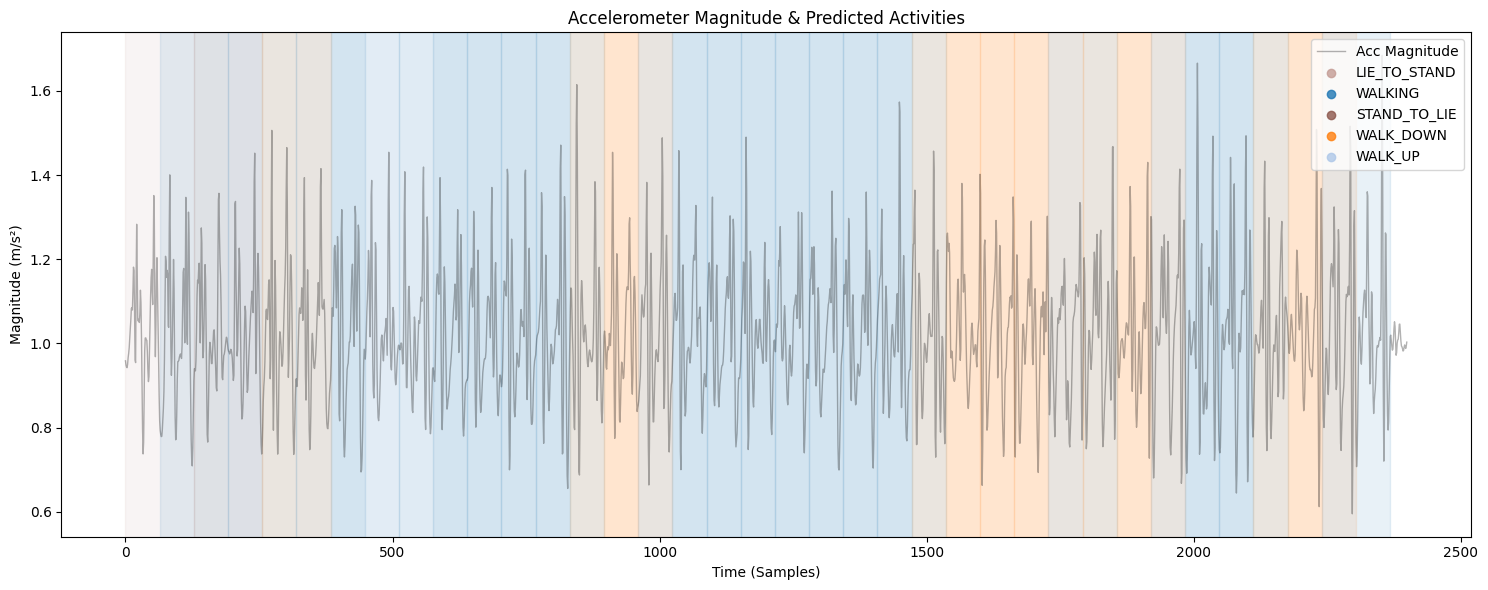


--- 📊 Classification Report ---
WALKING: 61.1%
WALK_UP: 2.8%
WALK_DOWN: 30.6%
STAND_TO_LIE: 2.8%
LIE_TO_STAND: 2.8%


In [11]:
def classify_new_file(acc_path, gyro_path):
    print(f"Processing {acc_path}...")
    
    # 1. Load Data
    try:
        df_acc = pd.read_csv(acc_path)
        df_gyro = pd.read_csv(gyro_path)
    except FileNotFoundError:
        print("Files not found. Please upload 'Accelerometer.csv' and 'Gyroscope.csv'.")
        return

    # 2. Rename columns to standard x,y,z
    # (Simple logic to handle different CSV headers)
    def standardize_columns(df):
        rename_map = {}
        for col in df.columns:
            if 'time' in col.lower(): rename_map[col] = 'time'
            elif 'x' in col.lower(): rename_map[col] = 'x'
            elif 'y' in col.lower(): rename_map[col] = 'y'
            elif 'z' in col.lower(): rename_map[col] = 'z'
        return df.rename(columns=rename_map)[['time', 'x', 'y', 'z']]

    df_acc = standardize_columns(df_acc)
    df_gyro = standardize_columns(df_gyro)
    
    # Convert g to m/s^2 (Standard for HAPT)
    df_acc[['x', 'y', 'z']] = df_acc[['x', 'y', 'z']] / 9.80665

    # 3. Resample to 50Hz (match training data)
    # Create a new common timeline
    start_time = max(df_acc['time'].min(), df_gyro['time'].min())
    end_time = min(df_acc['time'].max(), df_gyro['time'].max())
    new_timeline = np.arange(start_time, end_time, 1.0/FS)

    def resample_dataframe(df, target_time):
        df = df.set_index('time')
        # Reindex interpolates missing values
        df_resampled = df.reindex(df.index.union(target_time)).interpolate(method='linear')
        # Keep only the target timestamps
        return df_resampled.reindex(target_time).values

    acc_data = resample_dataframe(df_acc, new_timeline)
    gyro_data = resample_dataframe(df_gyro, new_timeline)

    # 4. Feature Extraction Loop
    body_acc, gravity = separate_gravity(acc_data, FS)
    full_signal = np.hstack([body_acc, gyro_data, acc_data])
    
    raw_windows_phy = []
    features_phy = []
    
    for i in range(0, len(full_signal) - WINDOW_SIZE, OVERLAP):
        window = full_signal[i : i + WINDOW_SIZE]
        
        raw_windows_phy.append(window)
        features_phy.append(extract_features(window))
        
    if len(raw_windows_phy) == 0:
        print("Not enough data for a window.")
        return

    # 5. Prepare Tensors
    # Transpose Raw: (N, 9, 128)
    X_raw_phy = np.array(raw_windows_phy).transpose(0, 2, 1)
    
    # Scale Features: Use the scaler fitted on training data
    X_feat_phy = scaler.transform(np.array(features_phy))

    # 6. Predict
    model.eval()
    with torch.no_grad():
        t_raw = torch.FloatTensor(X_raw_phy).to(device)
        t_feat = torch.FloatTensor(X_feat_phy).to(device)
        
        outputs = model(t_raw, t_feat)
        _, predictions = torch.max(outputs, 1)

    # 7. Visualization: Plot Magnitude with Colored Predictions
    print("Generating Visualization...")
    plt.figure(figsize=(15, 6))
    
    # Calculate Magnitude (Euclidean Norm) of the accelerometer data
    acc_mag = np.linalg.norm(acc_data, axis=1)
    
    # Plot the base signal in neutral color
    plt.plot(acc_mag, color='black', alpha=0.3, linewidth=1, label='Acc Magnitude')
    
    # Prepare for coloring
    # We use tab20 because we have up to 12 classes
    cmap = plt.get_cmap('tab20')
    window_starts = list(range(0, len(full_signal) - WINDOW_SIZE, OVERLAP))
    added_labels = set()
    
    # Iterate through every window prediction
    for i, start_idx in enumerate(window_starts):
        if i >= len(predictions): break
        
        pred_class = predictions[i].item()
        label_name = HAPT_LABELS.get(pred_class, "Unknown")
        
        # Get a unique color for this class (normalize 0-20)
        color = cmap(pred_class % 20)
        
        # Highlight the window area
        # We use low alpha (transparency) because windows overlap by 50%
        plt.axvspan(start_idx, start_idx + WINDOW_SIZE, color=color, alpha=0.1)
        
        # Add to legend only if we haven't seen this class yet
        if pred_class not in added_labels:
            plt.scatter([], [], color=color, label=label_name, alpha=0.8)
            added_labels.add(pred_class)
            
    plt.title("Accelerometer Magnitude & Predicted Activities")
    plt.xlabel("Time (Samples)")
    plt.ylabel("Magnitude (m/s²)")
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

    # 8. Statistics
    print("\n--- 📊 Classification Report ---")
    unique_classes, counts = np.unique(predictions.cpu().numpy(), return_counts=True)
    total_counts = sum(counts)
    
    for cls_idx, count in zip(unique_classes, counts):
        percentage = (count / total_counts) * 100
        label_name = HAPT_LABELS.get(cls_idx, "Unknown")
        print(f"{label_name}: {percentage:.1f}%")

# Run Inference
classify_new_file("Accelerometer.csv", "Gyroscope.csv")